In [2]:
import os

import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img

import random
import numpy as np
from matplotlib import pyplot as plt

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo'
  # augmented: data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo/aug'
except:
  import os
  from pathlib import Path
  here = os.getcwd()  # os.path.abspath(os.path.dirname(__file__))
  data_path = str(Path(here).joinpath('../data/toy/fluo'))

print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

image_size = (1024, 512)
input_shape = (*image_size, 1)
verbose = 1
batch_size = 3
epochs = 25
best_model_weights = 'model.h5'

getting data from /home/h4/stfo194b/rp/martin/attila/unet/../data/toy/fluo, folders there are: ['images', 'masks']


In [3]:
def get_data(imgs_path, masks_path, im_size):
    """ Get and resize train images and masks """

    im_height, im_width = im_size
    list_imgs = next(os.walk(imgs_path))[2]
    X = np.zeros((len(list_imgs), im_width, im_height, 1), dtype=np.float32)
    y = np.zeros((len(list_imgs), im_width, im_height, 1), dtype=np.float32)
    
    for i, img_name in enumerate(list_imgs):
        mask_name = img_name.replace('img_', 'mask_')
        
        # load images
        img = img_to_array(load_img(imgs_path + '/' + img_name, color_mode = "grayscale"))
        img = resize(img, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # load masks
        mask = img_to_array(load_img(masks_path + '/' + mask_name, color_mode = "grayscale"))
        mask = resize(mask, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # save images
        X[i, ..., 0] = img.squeeze() / 255
        y[i] = mask / 255

    return X, y

# get data
X, y = get_data(data_path + '/images', data_path + '/masks', image_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15)  # split train and test

/software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


9

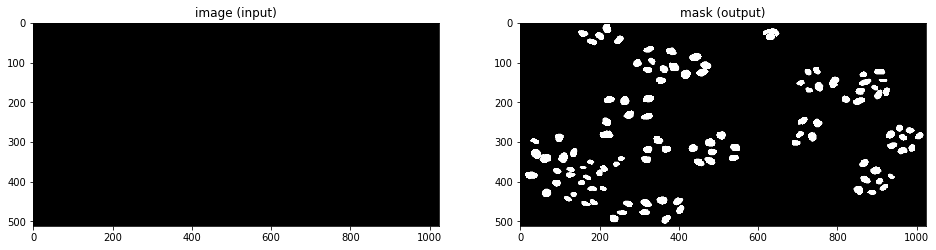

In [4]:
def plot_train_sample(X, y, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('image (input)')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('mask (output)')

    return ix

def plot_pred_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[0].set_title('image + mask')

    ax[1].imshow(preds[ix].squeeze(), cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[1].set_title('predicted + original mask')

    return ix

def plot_results(results):
    plt.figure(figsize=(24, 8))

    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    # plt.plot(results.history["accuracy"], label="accuracy")
    # plt.plot(results.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

    plt.xlabel("epochs")
    plt.ylabel("log loss")
    plt.legend()

plot_train_sample(X_train, y_train)  # check if training data looks all right

In [5]:
def unet(input_size, dropout, batch_norm):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    if batch_norm:
        conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    if batch_norm:
        conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    if batch_norm:
        conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    if batch_norm:
        conv4 = BatchNormalization(axis=3)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    return Model(inputs = inputs, outputs = conv10)


model = unet((512, 1024, 1), 0.5, True)
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.summary()

W1027 12:15:25.105646 35184372383184 deprecation.py:506] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1027 12:15:25.155451 35184372383184 deprecation.py:323] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(best_model_weights, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
]
results = model.fit(X_train, y_train, batch_size=4, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))

plot_results(results)

model.load_weights(best_model_weights)  # load best model
model.evaluate(X_valid, y_valid, verbose=verbose)  # evaluate on validation set

preds_train = model.predict(X_train, verbose=verbose)  # predict
preds_val = model.predict(X_valid, verbose=verbose)

Train on 78 samples, validate on 14 samples
Epoch 1/25
76/78 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9320
Epoch 00001: loss improved from inf to 0.03161, saving model to model.h5
78/78 [==============================] - 36s 460ms/sample - loss: 0.0316 - acc: 0.9312 - val_loss: 0.0244 - val_acc: 0.9280
Epoch 2/25
76/78 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9307
Epoch 00002: loss improved from 0.03161 to 0.00261, saving model to model.h5
78/78 [==============================] - 17s 217ms/sample - loss: 0.0026 - acc: 0.9312 - val_loss: 0.0505 - val_acc: 0.9280
Epoch 3/25
76/78 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9308
Epoch 00003: loss improved from 0.00261 to 0.00230, saving model to model.h5
78/78 [==============================] - 17s 217ms/sample - loss: 0.0023 - acc: 0.9312 - val_loss: 0.0513 - val_acc: 0.9280
Epoch 4/25
76/78 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9310
E

In [ ]:
# plot_pred_sample(X_train, y_train, preds_train)  # predictions on training data
plot_pred_sample(X_valid, y_valid, preds_val)  # predictions on test data